In [1]:
import tifffile as tf
from scipy import ndimage
from scipy import spatial
from scipy import special
import numpy as np
import pandas as pd

import os
import glob
import itertools as it
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
raw_src = '../raw/'

src = '../hpcc/'
dst = '../hpcc/traditional/'

wsrc = src + 'clean/'
tsrc = src + 'watershed/'
rsrc = src + 'rotated/'
ksrc = src + 'kernel/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

In [21]:
idname = '2014SBa'

rownum = 5
treenum = 53
nutnum = 2

bname = idname + '_R{}_T{}'.format(rownum, treenum)
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
    
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(wsrc + bname + '/' + fname + '.tif')
tissuefiles = tsrc + bname + '/' + fname + '_'
air  = tf.imread(tissuefiles + 'air.tif')
meat = tf.imread(tissuefiles + 'meat.tif')
shell= tf.imread(tissuefiles + 'shell.tif')
vein = tf.imread(tissuefiles + 'vein.tif')
protrusion = tf.imread(tissuefiles + 'protrusion.tif')
extshell = np.zeros_like(shell, dtype=np.bool)
extshell[protrusion == 3] = True

2014SBa_R5_T53_002
2014SBa_R5_T53_002


# Relative densities

In [54]:
raw_file = raw_src + bname + '/{:03d}.tif'.format(nutnum)
print(raw_file)
raw = tf.imread(raw_file)

zerofile = wsrc + bname + '/normalization/clean_zeroes{:03d}.csv'.format(nutnum)
cero = np.loadtxt(zerofile, dtype=int)
raw = raw[cero[1]:cero[4]-3, cero[2]:cero[5], cero[0]:cero[3]]

../raw/2014SBa_R5_T53/002.tif


In [57]:
if (raw.shape[0] < meat.shape[0]) and (meat.shape[0] - raw.shape[0] < 5):
    diff = meat.shape[0] - raw.shape[0]
    raw = tf.imread(raw_file)
    raw = raw[cero[1]:cero[4]+diff, cero[2]:cero[5], cero[0]:cero[3]]

In [56]:
print(cero, raw.shape, shell.shape, sep='\n')

[ 21   0  48 441 506 449]
(506, 401, 420)
(499, 401, 420)


In [36]:
if not raw.shape == meat.shape:
    raw = raw.swapaxes(0,1)

if not raw.shape == meat.shape:
    raw = raw.swapaxes(0,1)
    raw = raw.swapaxes(0,2)

if not raw.shape == meat.shape:
    raw = raw.swapaxes(0,2)
    raw = raw.swapaxes(1,2)

In [37]:
raw_meat = raw.copy()
raw_meat[meat == 0] = 0

raw_shell = raw.copy()
raw_shell[shell == 0] = 0

raw_vein = raw.copy()
raw_vein[vein == 0] = 0

maxval = np.max(raw)

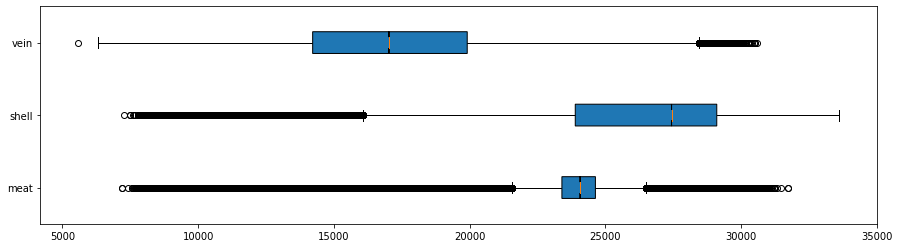

In [38]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
ax = np.atleast_1d(ax).ravel()

idx=0
boxes = [ raw_meat[raw_meat > 0], raw_shell[raw_shell > 0], raw_vein[raw_vein > 0] ]
labels = ['meat','shell','vein']
ax[idx].boxplot(boxes, notch=True, vert=False, patch_artist=True, labels=labels);

In [39]:
rho_meat = np.mean(raw_meat[raw_meat > 0])
rho_shell = np.mean(raw_shell[raw_shell > 0])
rho_vein = np.mean(raw_vein[raw_vein > 0])

q50_meat = np.median(raw_meat[raw_meat > 0])
q50_shell = np.median(raw_shell[raw_shell > 0])
q50_vein = np.median(raw_vein[raw_vein > 0])

rho_mvs = rho_meat/rho_shell
rho_vvs = rho_vein/rho_shell
rho_vvm = rho_vein/rho_meat

print(maxval, rho_meat, rho_shell, rho_vein, sep='\t')
print(maxval, q50_meat, q50_shell, q50_vein, sep='\t')
print(rho_mvs, rho_vvs, rho_vvm, sep='\t')

33599	23556.873790580405	25932.63399587031	17156.008014868137
33599	24066.0	27434.0	17025.0
0.9083872388100555	0.6615605656409672	0.72828033835832


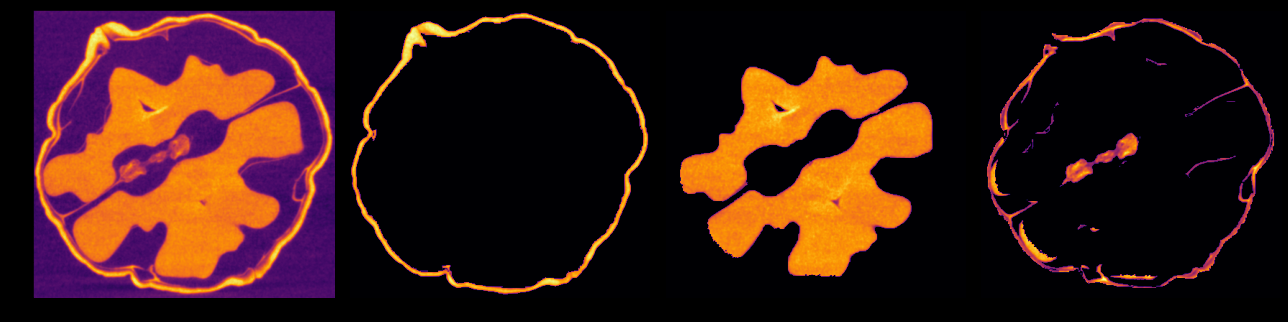

In [40]:
k = 240
fig, ax = plt.subplots(1,4,figsize=(18,5), sharex=True, sharey=True, facecolor='k')
ax =np.atleast_1d(ax).ravel()
ss = np.s_[k,:,:]
i = 0
ax[i].imshow(raw[ss], vmax=maxval, vmin=0, cmap='inferno'); i+=1
ax[i].imshow(shell[ss], vmin=0, cmap='inferno'); i+=1
ax[i].imshow(meat[ss],  vmin=0, cmap='inferno'); i+=1
ax[i].imshow(vein[ss], vmin=0, cmap='inferno'); i+=1

fig.tight_layout();

### Load rotations and phenotypes

In [41]:
filename = rsrc + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
rotX, _, _ = data[13]
tipvox = data[14]
rtipvox = data[15]
feretd = data[18]
nutvol, nutarea, nutvoxarea = data[19]
#nutvoxarea *= resol**2
chnutarea, chnutvol, _ = data[20]

tipvox[0] *= 1 + (-2*rotX)

chnutaratio = chnutarea/nutarea
chnutvratio = chnutvol/nutvol

In [42]:
print('Feret:\t', np.round(feretd,1), '\n')
print('*****', 'A[mm^2]', 'V[mm^3]', sep='\t')
print('Walnut', np.round(nutarea), np.round(nutvol), sep='\t')
print('Hull', np.round(chnutarea), np.round(chnutvol), sep='\t')
print('Hull/W', np.round(chnutaratio,3), np.round(chnutvratio,3), sep='\t')
####
print('\nVol Approx by a box of side:\t', np.round(np.cbrt(nutvol),2), 'mm')
print('Vol Approx by a ball of diam:\t', np.round(2*np.cbrt(3*nutvol/(4*np.pi)),2), 'mm')
####
print('\nArea Approx by a box of side:\t', np.round(np.sqrt(nutarea/6),2), 'mm')
print('Area Approx by a ball of diam:\t', np.round(2*np.sqrt(nutarea/(4*np.pi)),2), 'mm')

Feret:	 [37.2 31.1 31.5] 

*****	A[mm^2]	V[mm^3]
Walnut	5274.0	17280.0
Hull	3376.0	17960.0
Hull/W	0.64	1.039

Vol Approx by a box of side:	 25.85 mm
Vol Approx by a ball of diam:	 32.08 mm

Area Approx by a box of side:	 29.65 mm
Area Approx by a ball of diam:	 40.97 mm


### Other phenotypes

In [43]:
tvols = np.zeros(4)
for i,tissue in enumerate([air, meat, shell, vein]):
    tvols[i] = np.sum(tissue > 0)

tvols = tvols.astype(float)*(resol**3)

tvolr = tvols/nutvol
print(np.round(tvolr*100,2), np.round(np.sum(tvolr)), sep='\n')

[38.47 37.96 11.84 11.72]
1.0


### Sphericity

In [44]:
nutva3d = (nutarea ** 3)/(36*np.pi*nutvol**2)
nutferet = np.max(feretd)/np.min(feretd)
nutsphr = np.cbrt(36 * np.pi * nutvol**2)/nutarea
shellrug = 1./nutsphr

In [45]:
c,b,a = np.sort(feretd)*.5

if a == c:
    area = 4*np.pi*a*a
else:
    t = np.arccos(c/a)
    s = np.arccos(c/b)
    k = np.sin(s)/np.sin(t)

    ellarea = c*c/(a*a)*special.ellipkinc(t, k*k) + np.sin(t)*np.sin(t)*special.ellipeinc(t, k*k)
    ellarea *= 2*np.pi*a*b/np.sin(t)
    ellarea += 2*np.pi*c*c

ellvolume = 4*np.pi*a*b*c/3
wwadell = np.cbrt(36*np.pi*ellvolume*ellvolume)/ellarea

wkrumbein = np.cbrt(b*c/(a*a))
wcorey = c/np.sqrt(a*b)
wsneed = np.cbrt(c*c/(a*b))
wjanke = c/np.sqrt((a**2 + b**2 + c**2)/3)
wequancy = c/a

print('{:.2f}\t{:.2f}\t{:.2f}'.format(a,b,c))
print(np.round([nutsphr, wwadell, wkrumbein, wcorey, wsneed, wjanke, wequancy],3), sep='\t')

18.60	15.73	15.55
[0.613 0.995 0.891 0.909 0.938 0.932 0.836]


## Kernel phenotypes

In [46]:
bimg = meat.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
kerarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
kervoxarea = np.sum(border)

print('Border made of\t', kervoxarea, 'pixels\n')
print('Nut surface area:\t', np.round(kerarea, 2), 'mm^2')
print('Approx by a square of size:\t', np.round(np.sqrt(kerarea),2), 'mm')

datapoints = np.asarray(np.nonzero(border))
datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol

mcoords = rotxyz @ datapoints

kminis = np.min(mcoords, axis=1)
kmaxes = np.max(mcoords, axis=1)
print(kmaxes - kminis)

Border made of	 693470 pixels

Nut surface area:	 6721.75 mm^2
Approx by a square of size:	 81.99 mm
[30.46461047 26.70505829 25.52917907]


In [47]:
khull = spatial.ConvexHull(mcoords.T)
kerlob = khull.area/kerarea
chkervratio = khull.volume/tvols[1]
print(kerlob, 1/kerlob, sep='\t')

0.37150903226482784	2.691724596583042


In [48]:
filename = ksrc + bname + '/' + fname + '_kernel.csv'
kpheno = pd.read_csv(filename, header=None, dtype={1:str}).values[0][2:].astype(float)

# 0   kerarea
# 1   kervol
# 2   charearatio
# 3   chivolratio
# 4   krumbein
# 5   corey
# 6   sneed
# 7   janke
# 8   c/a
# 9   suf
# 10  vol
# 11  hlength
# 12  alength

kerSR = kpheno[9]/kpheno[0]
kerVR = kpheno[10]/khull.volume
kersphr = np.cbrt(36 * np.pi * kpheno[1]**2)/kpheno[0]

print(kerSR, kerVR, kersphr, sep='\t')

0.024605120836757175	0.020062858037046192	0.25211777032719934


## Shell thickness

In [49]:
reload(wnut)
thickness = wnut.object_thickness(extshell, resol, NNN=4, K=5)[0]
thickness

0.6009762535065827

## Protruding shell

In [50]:
shellvols, _ = np.histogram(protrusion, [2, 4, 6, 10], range=(0,10))
shellvols = np.asarray([shellvols[0], shellvols[1]+shellvols[2]])
shellvols

array([4395387,  283899])

In [51]:
shellvols/np.sum(shellvols)
shellvols*resol**3

array([1921.86309421,  124.13355424])

# Data saving

In [52]:
tradpheno = np.hstack((feretd,
                       nutvol,
                       nutva3d, # rugosity ** 3
                       nutferet,
                       nutarea,
                       nutsphr, # wadell
                       chnutarea,
                       chnutvol,
                       chnutaratio,
                       1./chnutvratio,
                       wkrumbein,
                       wsneed,
                       tvols,
                       tvolr,
                       shellrug, # 1/wadell
                       thickness,
                       shellvols/np.sum(shellvols),
                       shellvols*resol**3,
                       kmaxes - kminis,
                       kerarea,
                       khull.volume,
                       khull.area,
                       kpheno[2:4],
                       kpheno[9:],
                       kersphr,
                       kerSR,
                       kerVR,
                       rho_mvs, rho_vvs, rho_vvm))
print(tradpheno.shape)

filename = wdst + fname + '_trad.csv'
print(filename)
foo = pd.DataFrame([bname, fname.split('_')[-1], *tradpheno]).T
foo

(46,)
../hpcc/traditional/2014SBa_R5_T53/2014SBa_R5_T53_002_trad.csv


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,2014SBa_R5_T53,002,37.1989,31.0971,31.4606,17280,4.34363,1.19622,5273.88,0.61289,...,165.389,224.858,10.0024,14.9738,0.252118,0.0246051,0.0200629,0.908387,0.661561,0.72828


In [53]:
foo.to_csv(filename, header=False, index=False)

In [ ]:
bar = pd.read_csv(filename, header=None, dtype={1:str})

In [ ]:
bar